# Taller 1 - Datos funcionales

## 1.0. Importación de datos

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfda

archivo_mat = "../Datos/data.mat"
datos = sio.loadmat(archivo_mat)
# cambiar 'X' en dim 268x571x7
organizado=datos["X"].reshape(268, 571, 7, order='F')

# 268: "Pruebas"
# 7: longitudes de onda
# 571: Resultados

organizado


array([[[ 0.279,  0.234,  0.326, ...,  2.157,  0.839,  1.472],
        [ 0.276,  0.245,  0.33 , ...,  2.299,  0.828,  1.591],
        [ 0.276,  0.259,  0.334, ...,  2.486,  0.816,  1.829],
        ...,
        [ 8.038,  8.   ,  7.305, ..., 15.022, 13.685, 14.785],
        [ 7.88 ,  7.82 ,  7.15 , ..., 15.165, 13.625, 14.436],
        [ 7.72 ,  7.636,  6.924, ..., 15.42 , 13.621, 14.015]],

       [[ 0.266,  0.271,  0.403, ...,  2.268,  0.721,  1.418],
        [ 0.27 ,  0.271,  0.385, ...,  2.32 ,  0.707,  1.58 ],
        [ 0.272,  0.276,  0.376, ...,  2.425,  0.71 ,  1.867],
        ...,
        [ 7.833,  7.479,  7.044, ..., 14.296, 13.07 , 15.151],
        [ 7.688,  7.408,  6.903, ..., 14.094, 12.826, 14.895],
        [ 7.58 ,  7.371,  6.712, ..., 13.87 , 12.542, 14.494]],

       [[ 0.239,  0.277,  0.323, ...,  1.875,  0.846,  1.847],
        [ 0.234,  0.283,  0.319, ...,  2.027,  0.845,  1.862],
        [ 0.232,  0.288,  0.315, ...,  2.24 ,  0.835,  1.994],
        ...,
        [ 7.

/tmp/ipykernel_29297/355262297.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[wavelength].legend(bbox_to_anchor=(1.05, 1), loc='upper left')


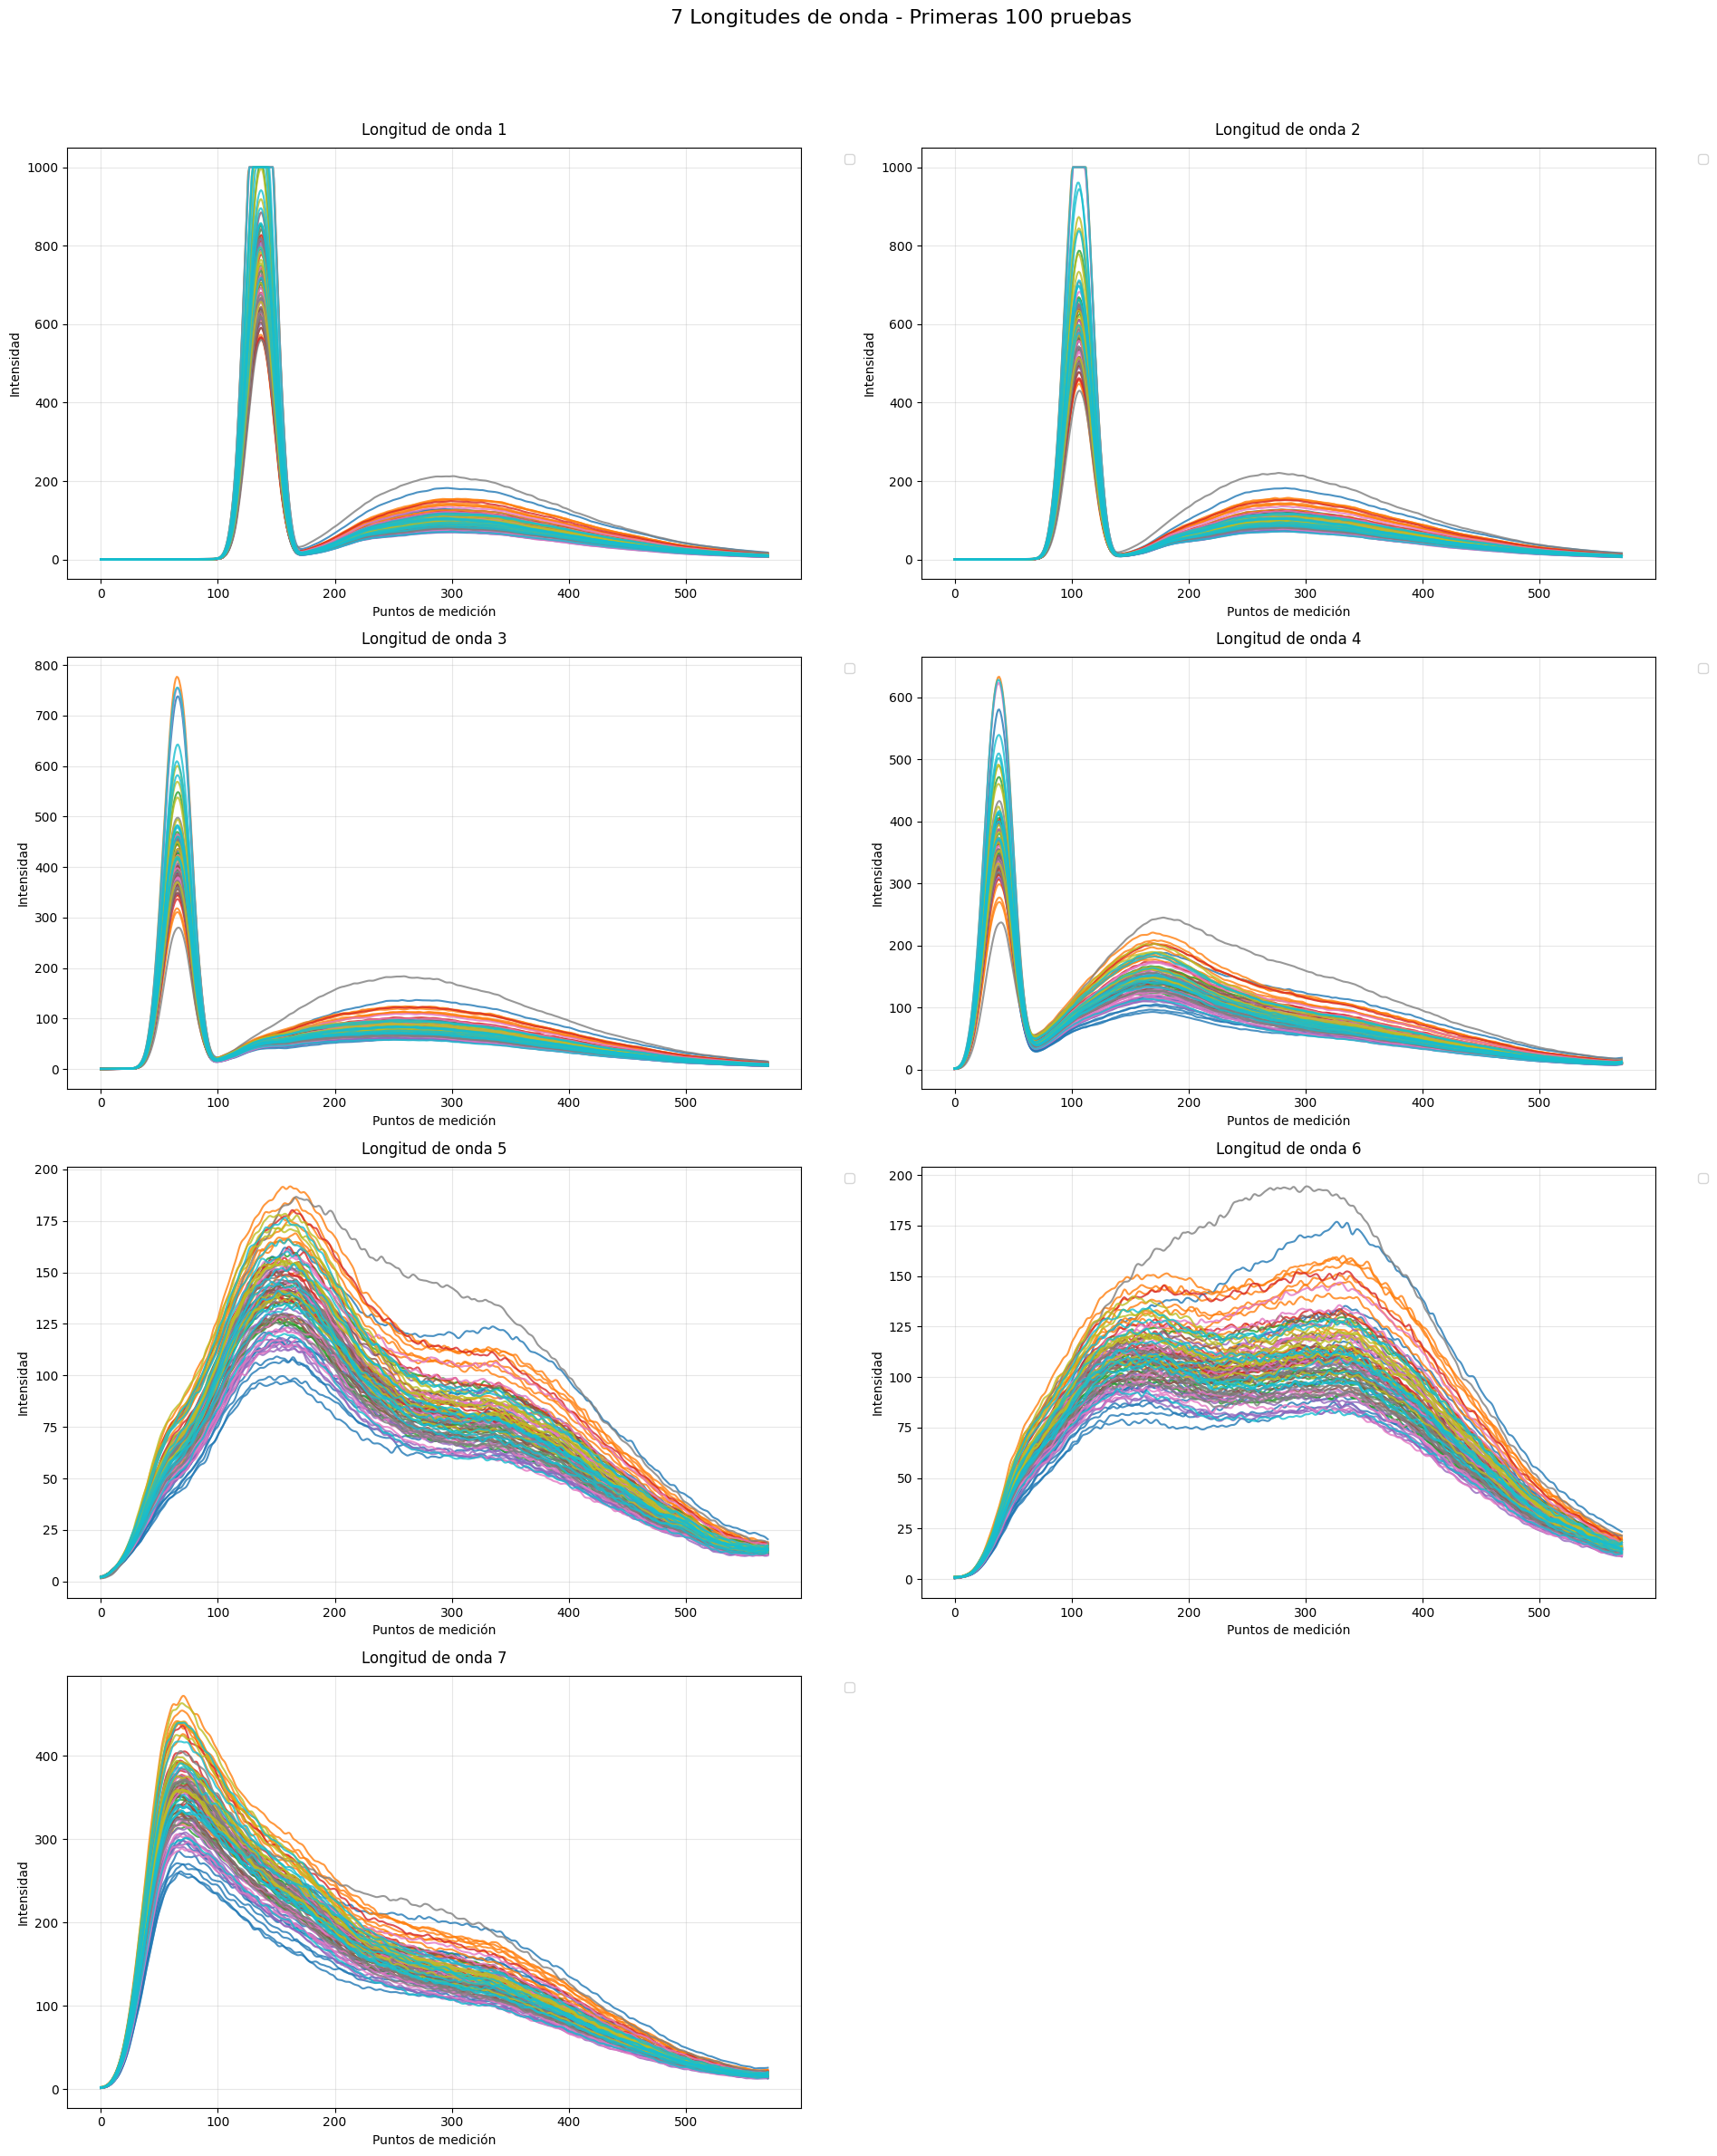

In [2]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.tab10(np.linspace(0, 1, 100))  # 10 colores distintos para las 10 pruebas

# Crear las 7 figuras, una para cada longitud de onda
fig, axes = plt.subplots(4, 2, figsize=(20, 25))
fig.suptitle('7 Longitudes de onda - Primeras 100 pruebas', fontsize=16)

# Aplanar el array de axes para facilitar la iteración
axes = axes.ravel()

# Crear el eje x (571 puntos)
x = np.arange(571)

# Iterar sobre las 7 longitudes de onda
for wavelength in range(7):
    # Graficar las primeras 10 pruebas en el mismo subplot
    for prueba in range(100):
        data = organizado[prueba, :, wavelength]
        axes[wavelength].plot(x, data, color=colors[prueba], 
                            linewidth=1.5,
                            alpha=0.8)  # Ligera transparencia para mejor visualización
    
    # Configurar cada subplot
    axes[wavelength].set_title(f'Longitud de onda {wavelength+1}', fontsize=12, pad=10)
    axes[wavelength].set_xlabel('Puntos de medición')
    axes[wavelength].set_ylabel('Intensidad')
    axes[wavelength].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[wavelength].grid(True, alpha=0.3)

# Ocultar el último subplot que queda vacío (ya que tenemos 7 longitudes y 8 espacios)
axes[-1].set_visible(False)

# Ajustar el espaciado entre subplots
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])

# Mostrar la figura
plt.show()

## 1.1 Realice un suavizado spline para cada una de las 268 muestras con $\lambda = 1$

In [3]:
import numpy as np
from scipy.sparse import diags
import skfda
from skfda.preprocessing.smoothing import BasisSmoother
from numba import jit
from typing import Tuple, List, Optional

@jit(nopython=True)
def calculate_criterion(n: int, tr_H: float, mse: float) -> float:
    if tr_H >= n:
        return np.inf
    denominator = n - tr_H
    return (n/denominator) * (mse/denominator)

class OptimizedSmoothingFinder:
    def __init__(self, X: np.ndarray, x: np.ndarray, basis: skfda.representation.basis.BSplineBasis):
        self.X = np.asarray(X).flatten()
        self.x = np.asarray(x).flatten()
        self.basis = basis
        self.n = len(self.x)
        
    def _precalculate_matrices(self) -> None:
        # Evaluar la base en los puntos x
        evaluation = self.basis.evaluate(self.x)
        self.basis_matrix = evaluation[0]  # Shape debe ser (n_points, n_basis)
        
        if len(self.basis_matrix.shape) == 3:
            self.basis_matrix = self.basis_matrix[0]
            
        # Verificar y corregir dimensiones si es necesario
        if self.basis_matrix.shape[0] != self.n:
            self.basis_matrix = self.basis_matrix.T
            
        # Precalcular BTB
        self.BTB = self.basis_matrix.T @ self.basis_matrix
        
        # Crear matriz de penalización
        n_basis = self.basis.n_basis
        D = np.zeros((n_basis-2, n_basis))
        for i in range(n_basis-2):
            D[i, i:i+3] = [1, -2, 1]
        self.P = D.T @ D
        
        # Verificar dimensiones
        print(f"Dimensiones de las matrices:")
        print(f"basis_matrix: {self.basis_matrix.shape}")
        print(f"BTB: {self.BTB.shape}")
        print(f"P: {self.P.shape}")
        
    def _calculate_hat_matrix_efficient(self, lambda_param: float) -> np.ndarray:
        try:
            # Resolver el sistema lineal
            coefficients = np.linalg.solve(
                self.BTB + lambda_param * self.P,
                self.basis_matrix.T
            )
            
            # Calcular matriz H
            H = self.basis_matrix @ coefficients
            return H
            
        except np.linalg.LinAlgError as e:
            print(f"Error en la resolución del sistema lineal: {e}")
            return None
        except ValueError as e:
            print(f"Error en las dimensiones: {e}")
            return None
        
    def find_best_parameter(self, 
                           lambda_range: Optional[Tuple[float, float]] = (-10, 1),
                           n_points: int = 20,
                           verbose: bool = True) -> float:
        # Precalcular matrices
        self._precalculate_matrices()
        
        smoothing_parameters = np.logspace(lambda_range[0], lambda_range[1], n_points)
        min_criterio = np.inf
        best_param = None
        
        for param in smoothing_parameters:
            try:
                H = self._calculate_hat_matrix_efficient(param)
                
                if H is None:
                    continue
                    
                y_pred = H @ self.X
                mse = np.mean((self.X - y_pred) ** 2)
                tr_H = np.trace(H)
                criterio = calculate_criterion(self.n, tr_H, mse)
                
                if criterio < min_criterio:
                    min_criterio = criterio
                    best_param = param
                    
                if verbose:
                    print(f"λ={param:.2e}, tr(H)={tr_H:.2f}, MSE={mse:.2e}, "
                          f"Criterio={criterio:.2e}")
                    
            except Exception as e:
                if verbose:
                    print(f"Error con λ={param:.2e}: {str(e)}")
                continue
        
        if best_param is None:
            best_param = smoothing_parameters[0]
            print(f"Advertencia: Usando primer valor como defecto: {best_param:.2e}")
            
        return best_param

def find_optimal_smoothing(X, x, basis, lambda_range=(-10, 1), n_points=20, verbose=True):
    optimizer = OptimizedSmoothingFinder(X, x, basis)
    return optimizer.find_best_parameter(
        lambda_range=lambda_range,
        n_points=n_points,
        verbose=verbose
    )

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skfda
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from sklearn.model_selection import KFold
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# Definir las longitudes de onda y sus nombres
wavelengths = {
    0: 'Y1=230',
    1: 'Y2=240',
    2: 'Y3=255',
    3: 'Y4=290',
    4: 'Y5=305',
    5: 'Y6=325',
    6: 'Y7=340'
}

# Crear la estructura de carpetas
base_path = "../Resultados/punto_1"
if not os.path.exists(base_path):
    os.makedirs(base_path)

# Crear subcarpetas para cada longitud de onda
for wave_idx, wave_name in wavelengths.items():
    wave_path = os.path.join(base_path, wave_name)
    if not os.path.exists(wave_path):
        os.makedirs(wave_path)

# Crear el dominio x
x = np.arange(275, 560.5, 0.5)

# Definir los parámetros de suavizado a probar
smoothing_parameters = np.logspace(-7, 0, 5)  # 20 valores entre 1e-7 y 1

# Calcular el número total de iteraciones
total_iterations = 1

# Crear una barra de progreso
with tqdm(total=total_iterations, desc="Procesando muestras") as pbar:
    # Para cada longitud de onda y cada muestra
    for wave_idx in range(1):
        for muestra in range(1):
            # Obtener los datos para esta muestra y longitud de onda
            X = organizado[muestra, :, wave_idx].flatten()       
            # 3. Crear una base B-Spline
            n_basis =  45 # Número de funciones base (ajusta según la complejidad de los datos)
            basis = BSplineBasis(domain_range=(275, 560), n_basis=n_basis)
                 
            ########################################## Encontrar el mejor parámetro de suavizado ###########################

            best_param = 1e-3
            
            fd = skfda.FDataGrid(data_matrix=X, grid_points=x)
            
            # 4. Suavizado penalizado
            smoother = skfda.preprocessing.smoothing.BasisSmoother(basis,smoothing_parameter=best_param)
            fd_smoothed = smoother.fit_transform(fd)
            
            
            # Crear la figura
            plt.figure(figsize=(12, 7))
    
            # Graficar los datos originales como puntos
            plt.scatter(x, X, c='blue', s=30, alpha=0.5, label='Datos originales')
            
            # Graficar la curva ajustada
            plt.plot(x, fd_smoothed(x)[0], 'r-', 
                    label=f'Ajuste B-spline (λ={best_param:.2e})',
                    linewidth=2)
            
            # Personalización del gráfico
            plt.title(f'Longitud de onda {wavelengths[wave_idx]} nm - Muestra {muestra}\n'
                    f'Bases B-spline: {n_basis}', fontsize=12)
            plt.xlabel('Longitud de onda (nm)', fontsize=11)
            plt.ylabel('Intensidad', fontsize=11)
            plt.legend(fontsize=10)
            plt.grid(True, alpha=0.3)
            
            # Ajustar los márgenes
            plt.tight_layout()
           
            
            # Guardar la figura
            output_path = os.path.join(base_path, wavelengths[wave_idx], 
                                     f'onda_{wave_idx}_muestra_{muestra}_lambda_{best_param:.2e}.png')
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()
            
            # Actualizar la barra de progreso
            pbar.update(1)

print("Proceso completado. Se han generado todas las imágenes con el ajuste penalizado optimizado por validación cruzada.")

Procesando muestras: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

Proceso completado. Se han generado todas las imágenes con el ajuste penalizado optimizado por validación cruzada.


# 1.2 La función media

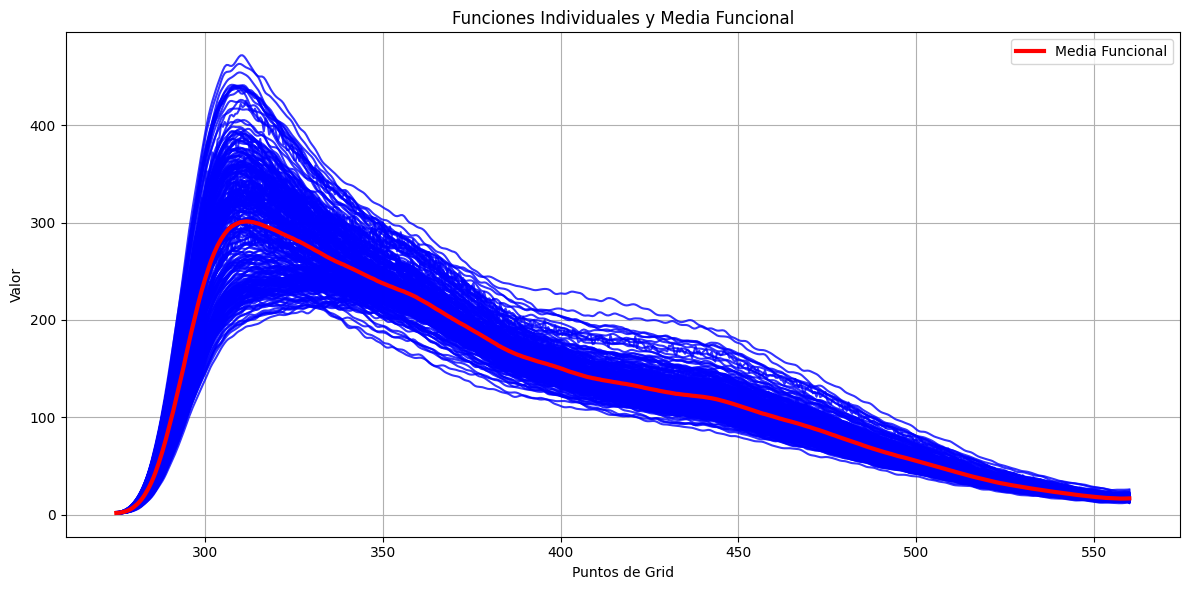

In [2]:
import numpy as np
import skfda
import matplotlib.pyplot as plt

# Array de datos proporcionado
x = np.arange(275, 560.5, 0.5)
X = organizado[:, :, 6]

fd = skfda.FDataGrid(data_matrix=X, grid_points=x)
wavelength = 6
# Calcular la media funcional
mean = skfda.exploratory.stats.mean(fd)

plt.figure(figsize=(12, 6))

# Graficar todas las curvas usando un bucle for
for prueba in range(268):
    data = organizado[prueba, :, wavelength]
    plt.plot(x, data, color="blue", linewidth=1.5, alpha=0.8)

# Calcular y graficar la media funcional en rojo
mean_data = np.mean(organizado[:, :, wavelength], axis=0)
plt.plot(x, mean_data, color='red', linewidth=3, label='Media Funcional')

plt.title('Funciones Individuales y Media Funcional')
plt.xlabel('Puntos de Grid')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Media recortada al 10%


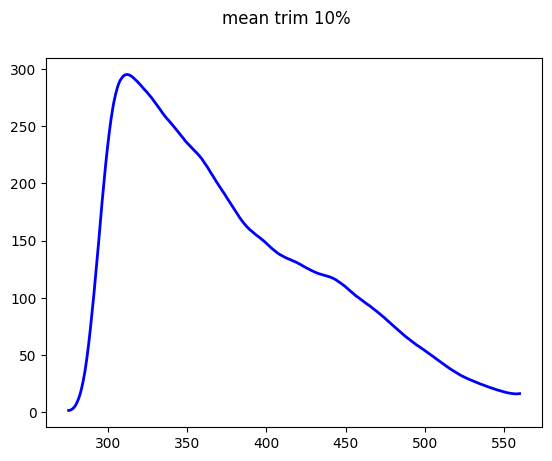

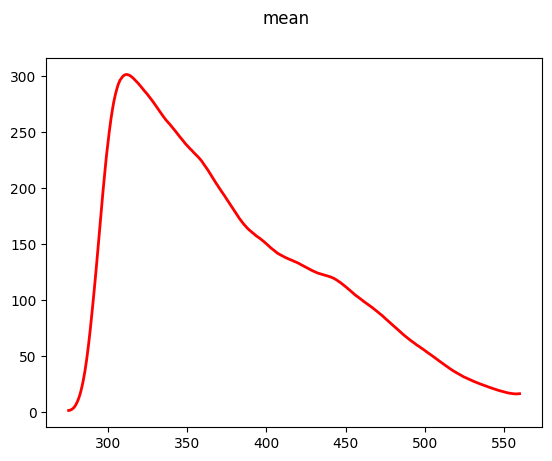

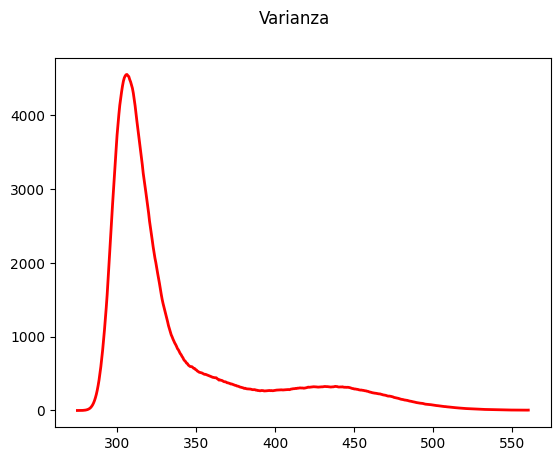

In [3]:
import numpy as np
import skfda
import matplotlib.pyplot as plt

# Array de datos proporcionado
x = np.arange(275, 560.5, 0.5)
wavelength = 6
X = organizado[:, :, wavelength]
fd = skfda.FDataGrid(data_matrix=X, grid_points=x)

mean_trim = skfda.exploratory.stats.trim_mean(fd, 0.1, depth_method=None)
mean_trim.dataset_name = f"mean trim 10%"
mean = skfda.exploratory.stats.mean(fd)
mean.dataset_name = f"mean"



mean_trim.plot(
    color='blue',
    linewidth=2,
    legend=True,
)
mean.plot(
    color='red',
    linewidth=2,
    legend=True,
)

var = skfda.exploratory.stats.var(fd)
var.dataset_name = f"Varianza"
var.plot(color='red',
    linewidth=2,
    legend=True,)

x1= 10



## La función covarianza

In [ ]:
cov = skfda.exploratory.stats.cov(fd)

